In [1]:
import numpy as np

import openqcs as op
import openqcs.tools as t
import openqcs.spinchain as sp
import openqcs.qcirc as qcirc
import openqcs.iterativ as it
from openqcs.statistic import bootstrap

import pyqcs

import matplotlib.pyplot as plt


In [2]:
a = 0.5
b = 0.5

dt = 0.05

H = sp.H_(a,b)
T = sp.T_(H, dt)


In [3]:
def apply_circuit(p, E0, E1, iSt=pyqcs.State.new_zero_state(1), n_sample=100, n_measure=1000, s=42):
    
    #np.random.seed(s)
    
    param0 = t.get_u2_param(E0)
    param1 = t.get_u2_param(E1)
    
    circ0 = qcirc.u2_to_circuit(0,param0)
    circ1 = qcirc.u2_to_circuit(0,param1)
    
    Meas_ = np.zeros((n_sample, 2), dtype=float)
    for i in range(n_sample):
        # draw random number
        q = np.random.rand()
        if q < p:
            psi = circ0 * iSt
        else:
            psi = circ1 * iSt

        
        res = pyqcs.sample(psi, 1, n_measure)
        
        for key, val in res.items():
            Meas_[i, key] = val/n_measure
            
            
    
    mean0, err0 = bootstrap(Meas_[:,0])
    mean1, err1 = bootstrap(Meas_[:,1])
    
    
    
    
    return mean0, err0, mean1, err1




time = 5.0
n_t = int(time/dt)

rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)

probs = np.zeros((n_t,), dtype=np.double)
errs = np.zeros((n_t, ), dtype=np.double)

data = np.zeros((n_t, 7), dtype=np.double)
data_cl = np.zeros((n_t, 4), dtype=np.double)

param = np.zeros((n_t, 2, 4), dtype=np.double)

for i in range(n_t):
    
    print("#", end="", flush=True)
    
    Ks = op.get_kraus_(T**i)
    rho = op.channel_(rho0, Ks)
    
    p, E0, E1, msg = it.it_kraus(rho0, rho, phase_check=False)
    param[i,0,:] = t.get_u2_param(E0)
    param[i,1,:] = t.get_u2_param(E1)
    
    probs[i] = p
    errs[i] = msg["err"]
        
    m0, e0, m1, e1 = apply_circuit(p, E0, E1)
    
    data[i,:] = [dt*i, m0, e0, m1, e1, rho[0,0].real, rho[1,1].real]
    
    
    
    

    
    

#

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/anaconda3/lib/python3.7/site-packages/pyqcs/gates/gate.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  BaseGate.__init__(self, BasicGate(type_, act, control, r, numpy.random.uniform))


###################################################################################################

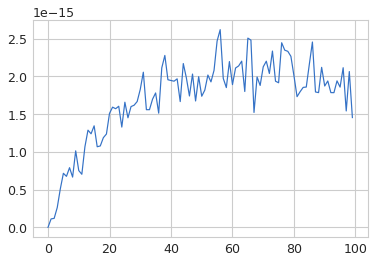

In [4]:
plt.figure()
plt.plot(errs)
plt.show()

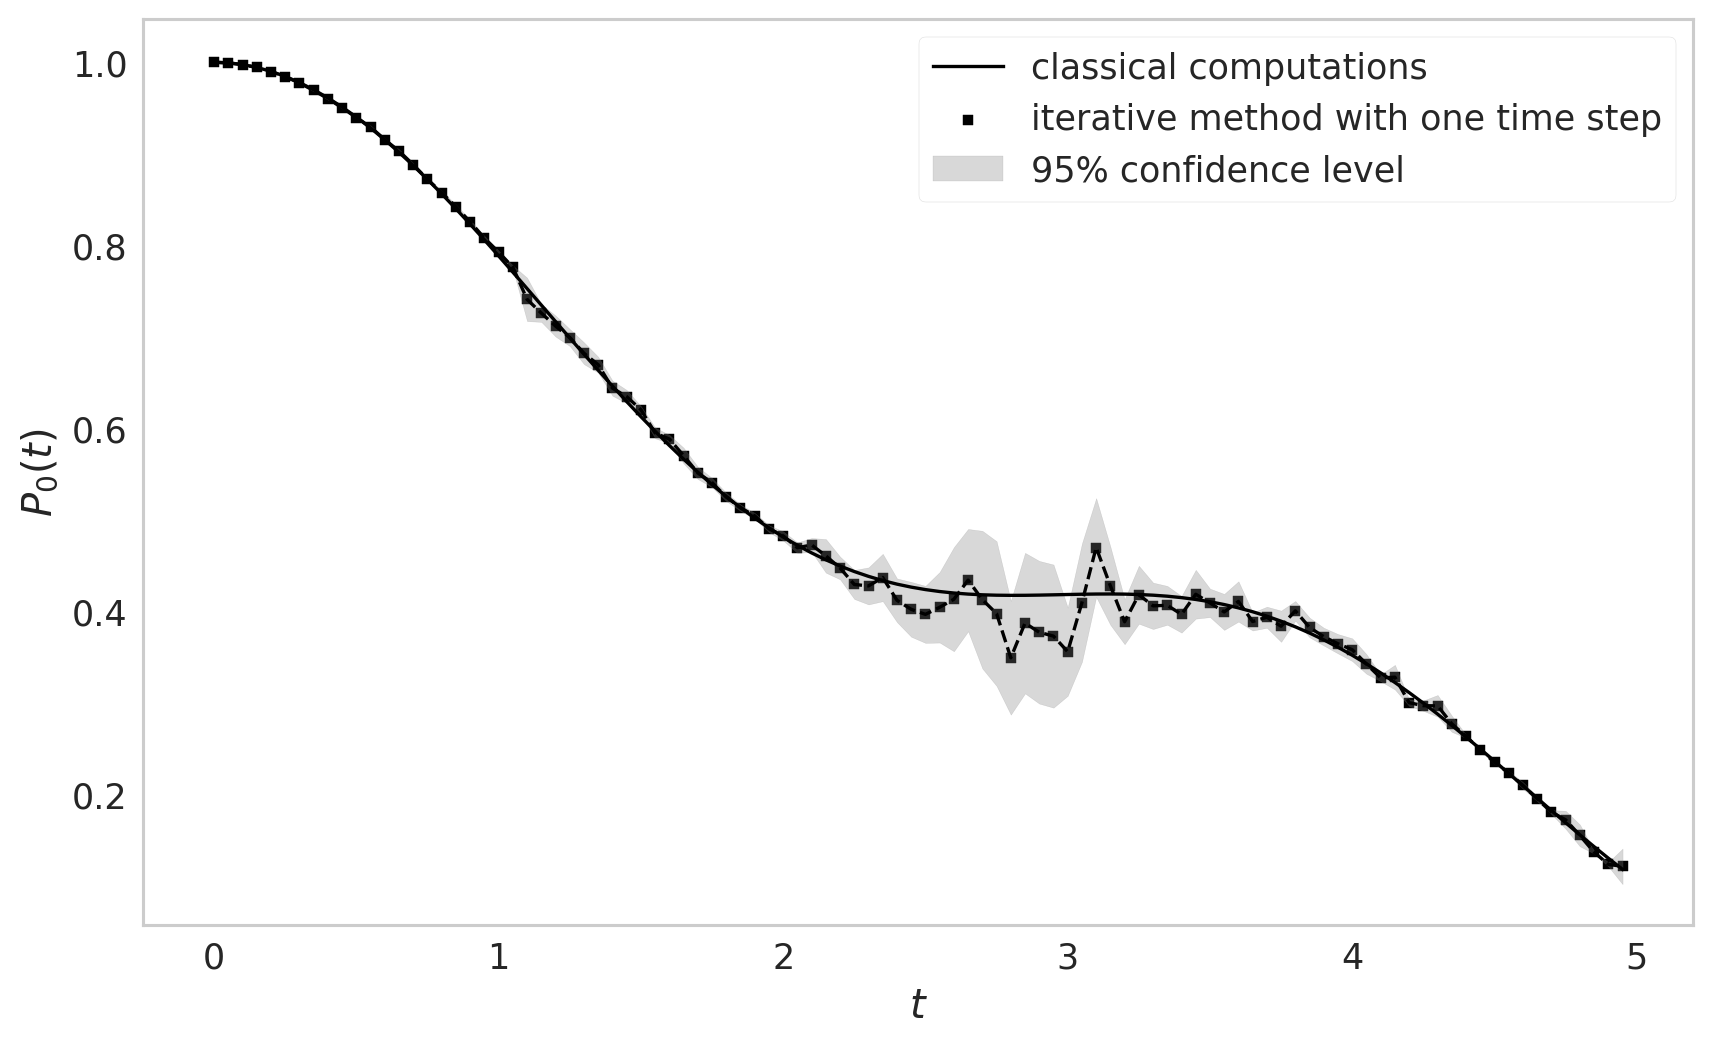

In [67]:
cls = ["black", "tab:orange"]

fig, axes = plt.subplots(1,1,figsize=(10,6), dpi=200)
axes.scatter(data[:,0], data[:,1], marker="s", s=12, color=cls[0], 
              label="iterative method with one time step")
axes.plot(data[:,0], data[:,1], linestyle="dashed", color=cls[0])
axes.fill_between(data[:,0], data[:,1]+1.96*data[:,2], data[:,1]-1.96*data[:,2], color="grey", alpha=.3, 
                 label="95% confidence level")
axes.plot(data[:,0], data[:,5], color=cls[0], label="classical computations")
axes.legend()
axes.grid(False)
axes.set_xlabel("$t$")
axes.set_ylabel("$P_0(t)$")
plt.savefig("iterative_method_1_time_step.png", format="png")
plt.show()

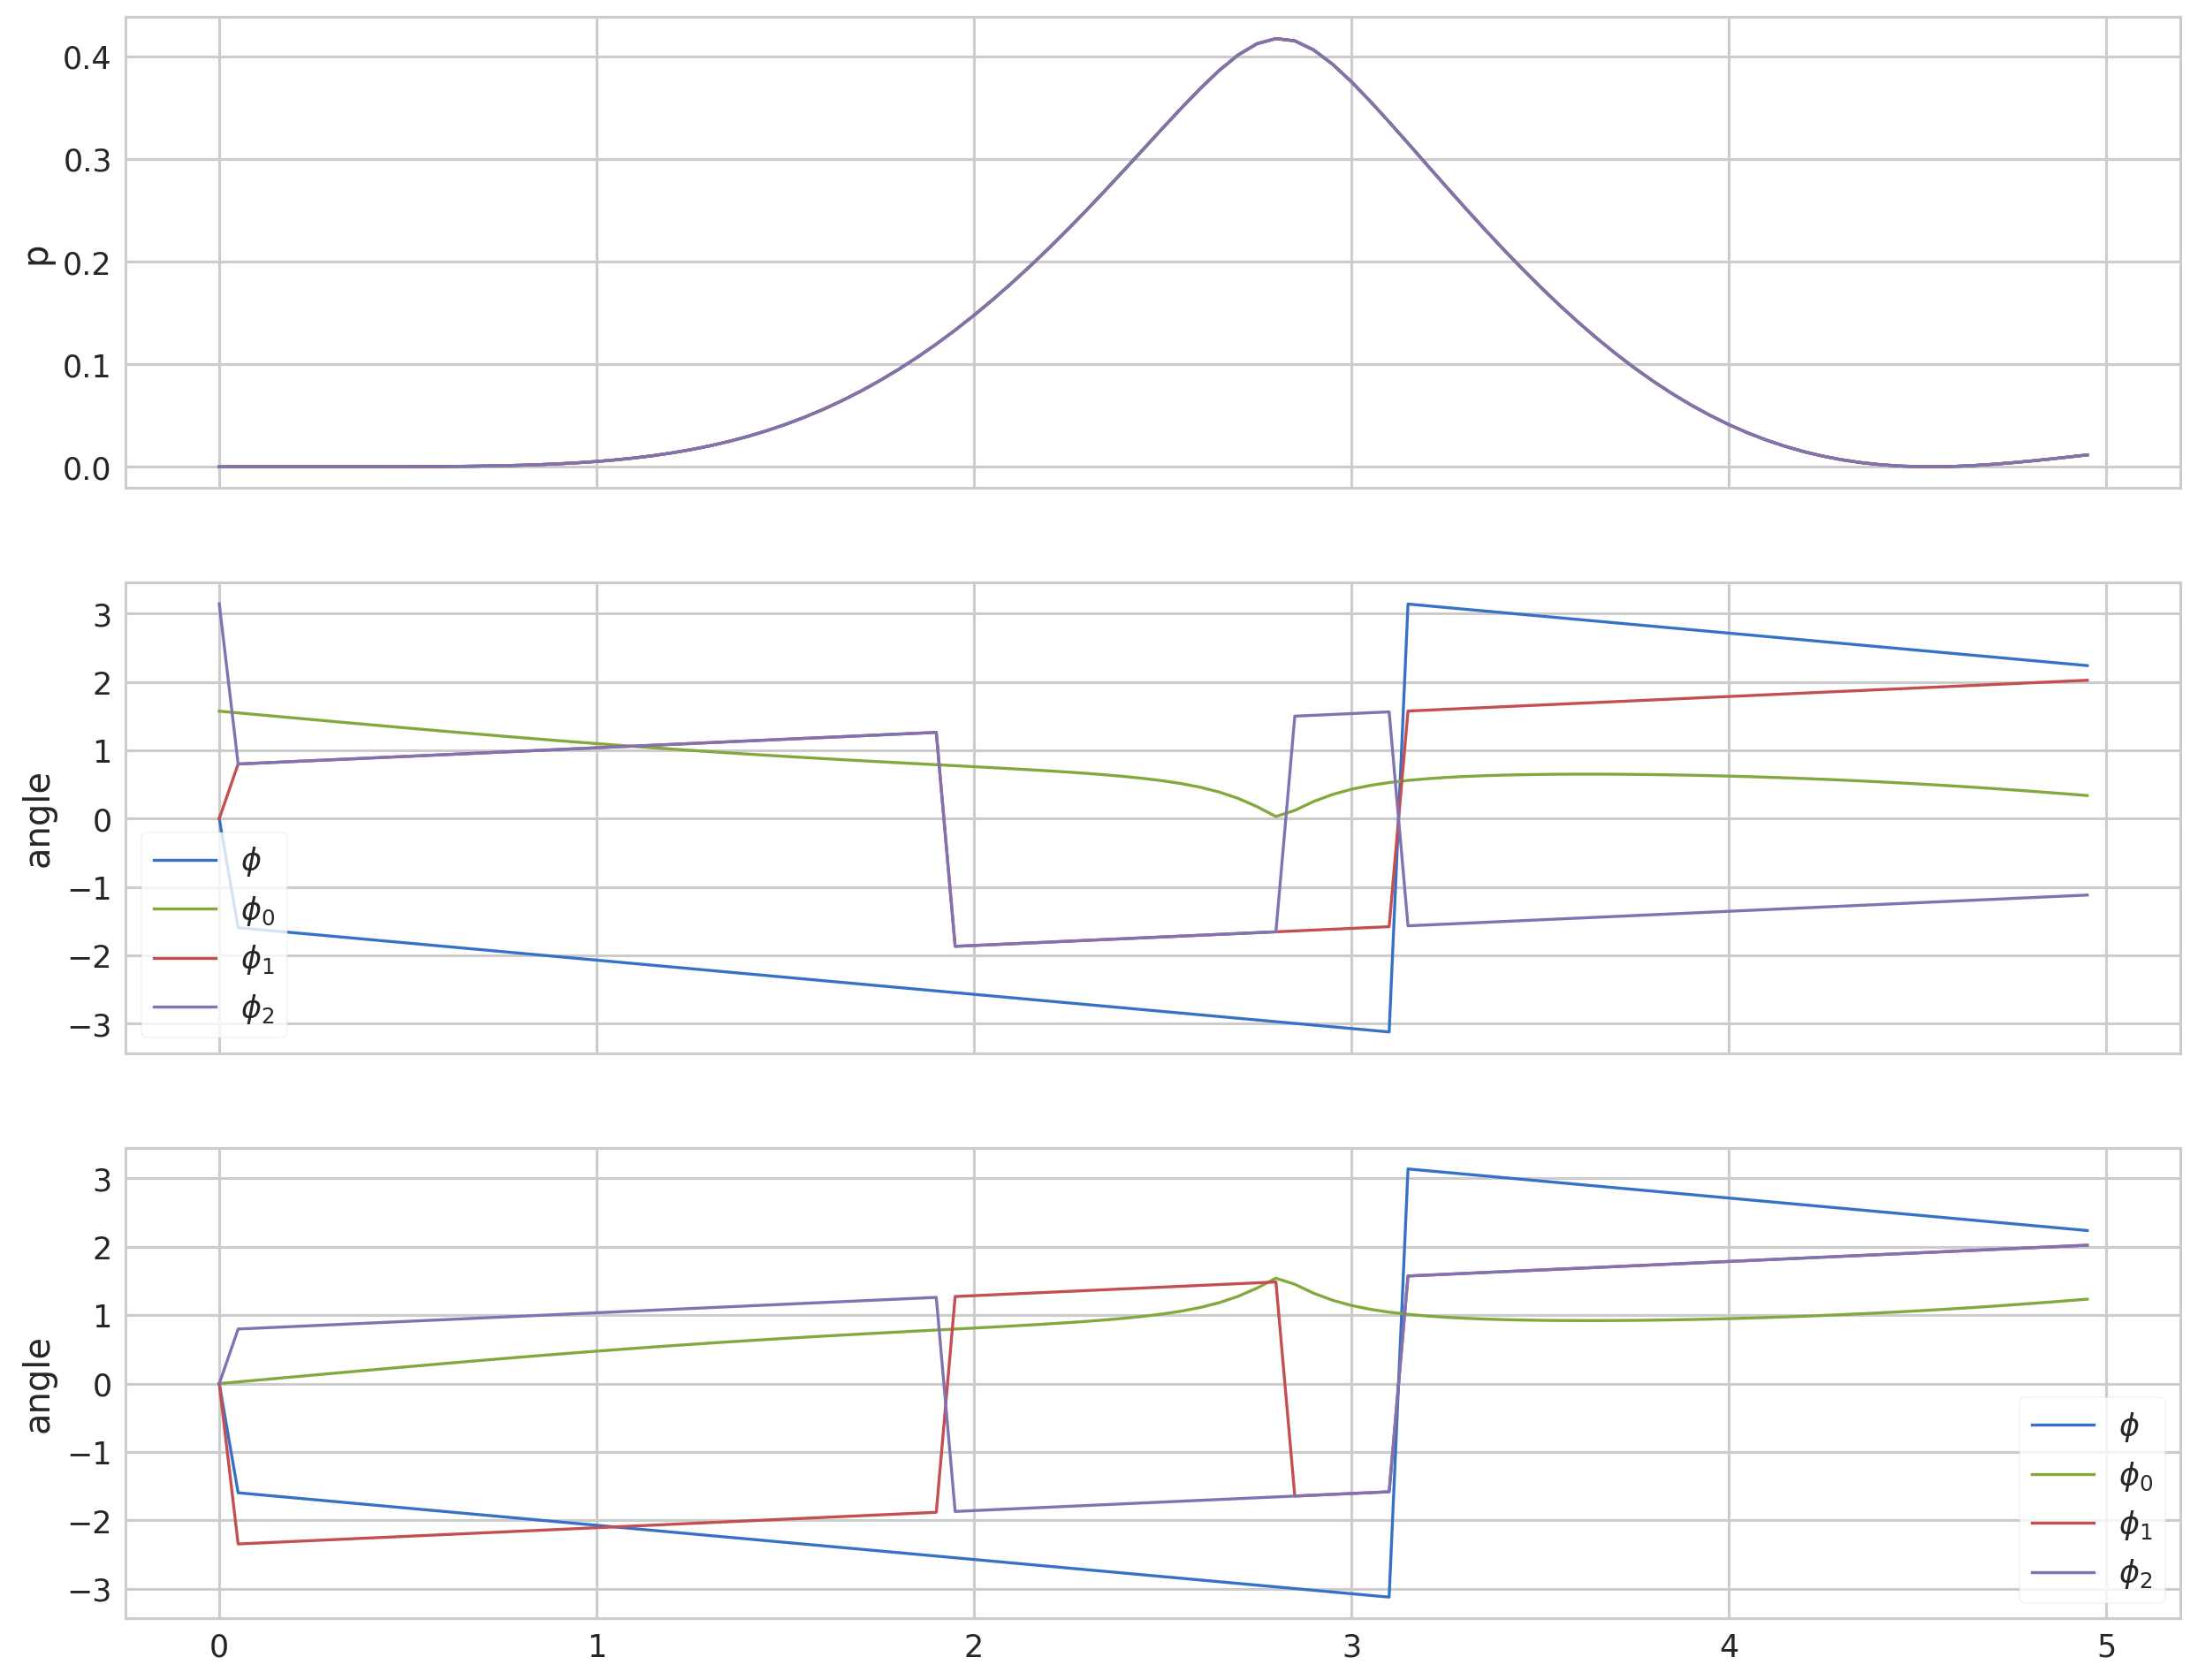

In [6]:
labels=[r"$\phi$", r"$\phi_0$", r"$\phi_1$", r"$\phi_2$"]
fig, axes = plt.subplots(3,1,figsize=(15,12), dpi=200, sharex=True)
for i in range(4):
    axes[0].plot(data[:,0], probs)
    axes[1].plot(data[:,0], param[:,0,i], label=labels[i])
    axes[2].plot(data[:,0], param[:,1,i], label=labels[i])

for i in range(1,3):
    axes[i].legend()
    
axes[0].set_ylabel("p")
axes[1].set_ylabel("angle")
axes[2].set_ylabel("angle")
plt.show()

In [17]:

t0=3.0
n0=int(t0/dt)
n_sample=10000
n_measure=1000


prob = probs[n0]

S0 = t.u2(param[n0,0,:])
S1 = t.u2(param[n0,1,:])

iSt = pyqcs.State.new_zero_state(1)
print("initial state |i>:")
print(iSt)

circ0 = qcirc.u2_to_circuit(0,param[n0,0,:])
circ1 = qcirc.u2_to_circuit(0,param[n0,1,:])

measurements=np.zeros((n_sample, 2), dtype=float)

print("#"*100)
for i in range(n_sample):
    if i % (n_sample//100) == n_sample//100 - 1:
        print("#", end="", flush=True)
    q = np.random.rand()
    if q < prob:
        psi=circ0*iSt
    else:
        psi=circ1*iSt
        
    sol=pyqcs.sample(psi,1,n_measure)
    for key, val in sol.items():
        measurements[i,key] = val/n_measure

print()
print(np.mean(measurements[:,0]))
    
print(apply_circuit(prob, S0, S1))
    

initial state |i>:
(1+0j)*|0b0>
####################################################################################################
####################################################################################################
0.4165293
(0.41528099999999996, 0.025734355422275514, 0.595129, 0.03492553176402614)


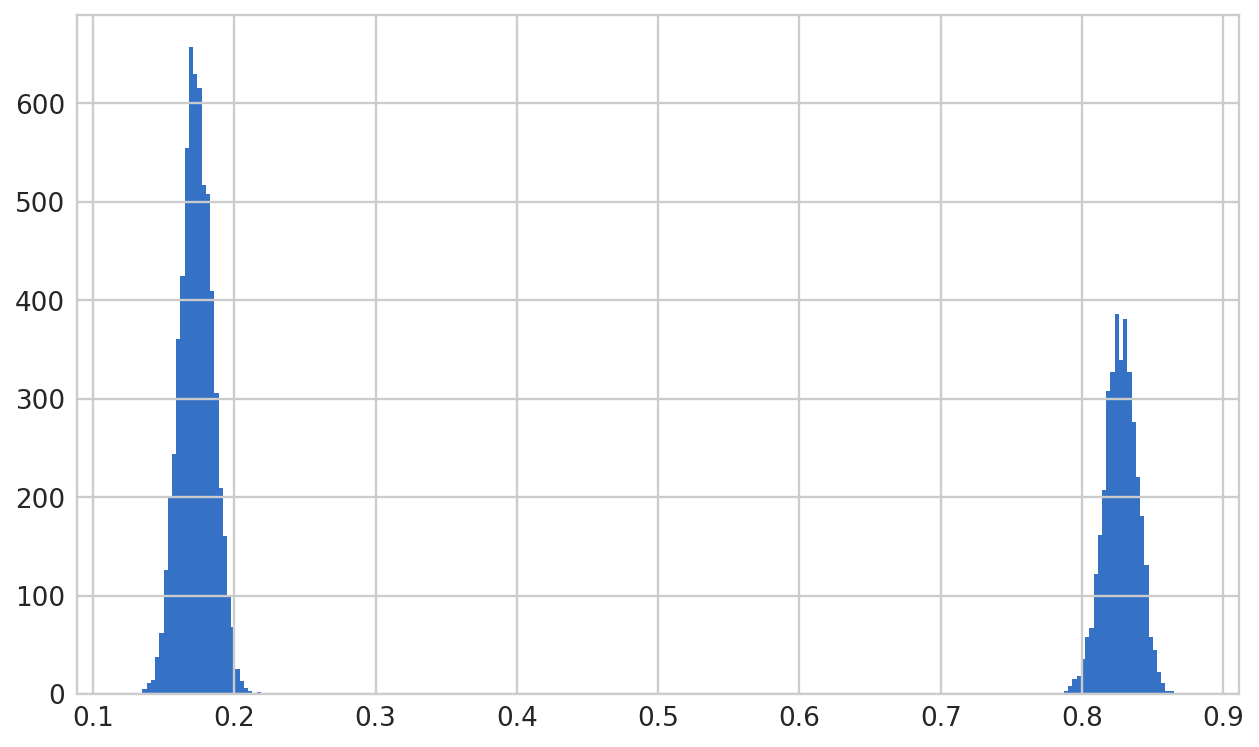

In [22]:

plt.figure(figsize=(10,6),dpi=150)

bins = 250
plt.hist(measurements[:,0], bins=bins, histtype="bar")
#plt.hist(measurements[:,1], bins=bins, histtype="step")
plt.show()

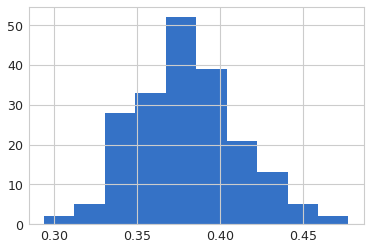

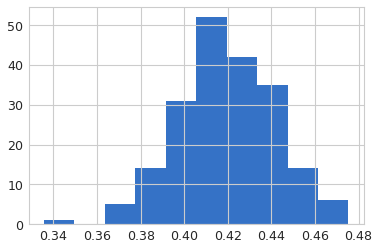

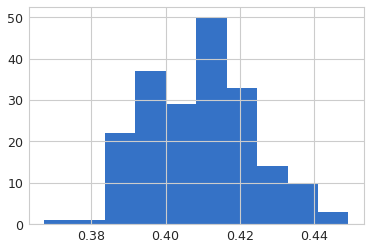

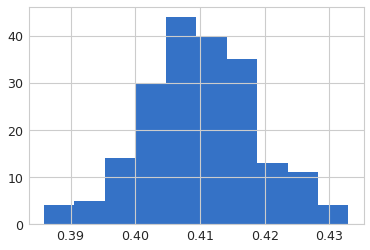

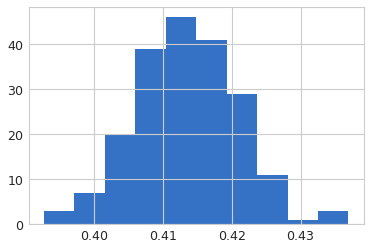

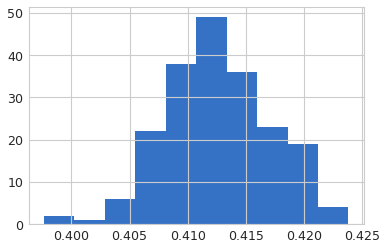

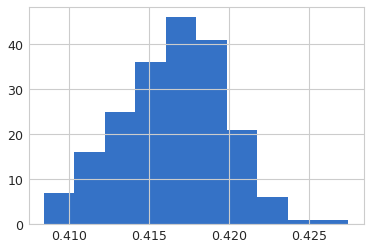

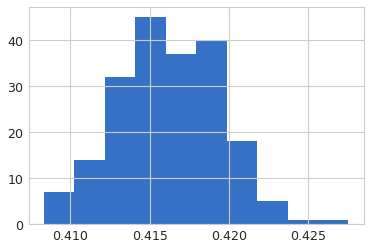

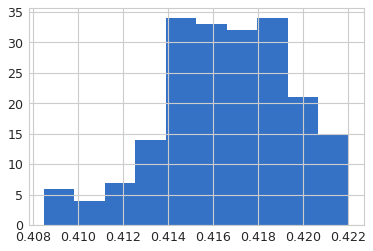

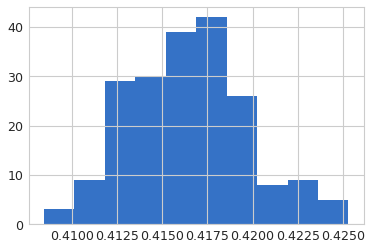

In [36]:
def plot_means(data, n_means=100, n_bins=10):
    
    means = np.zeros(n_means, dtype=np.double)
    for i in range(n_means):
        means[i] = np.mean(np.random.choice(data, data.shape[0], replace=True))
        
    plt.figure()
    plt.hist(means)
    plt.show()

n_vals = np.logspace(2, 5, 10, dtype=int)
for val in n_vals:
    plot_means(measurements[:val,0], n_means=200)

    
    

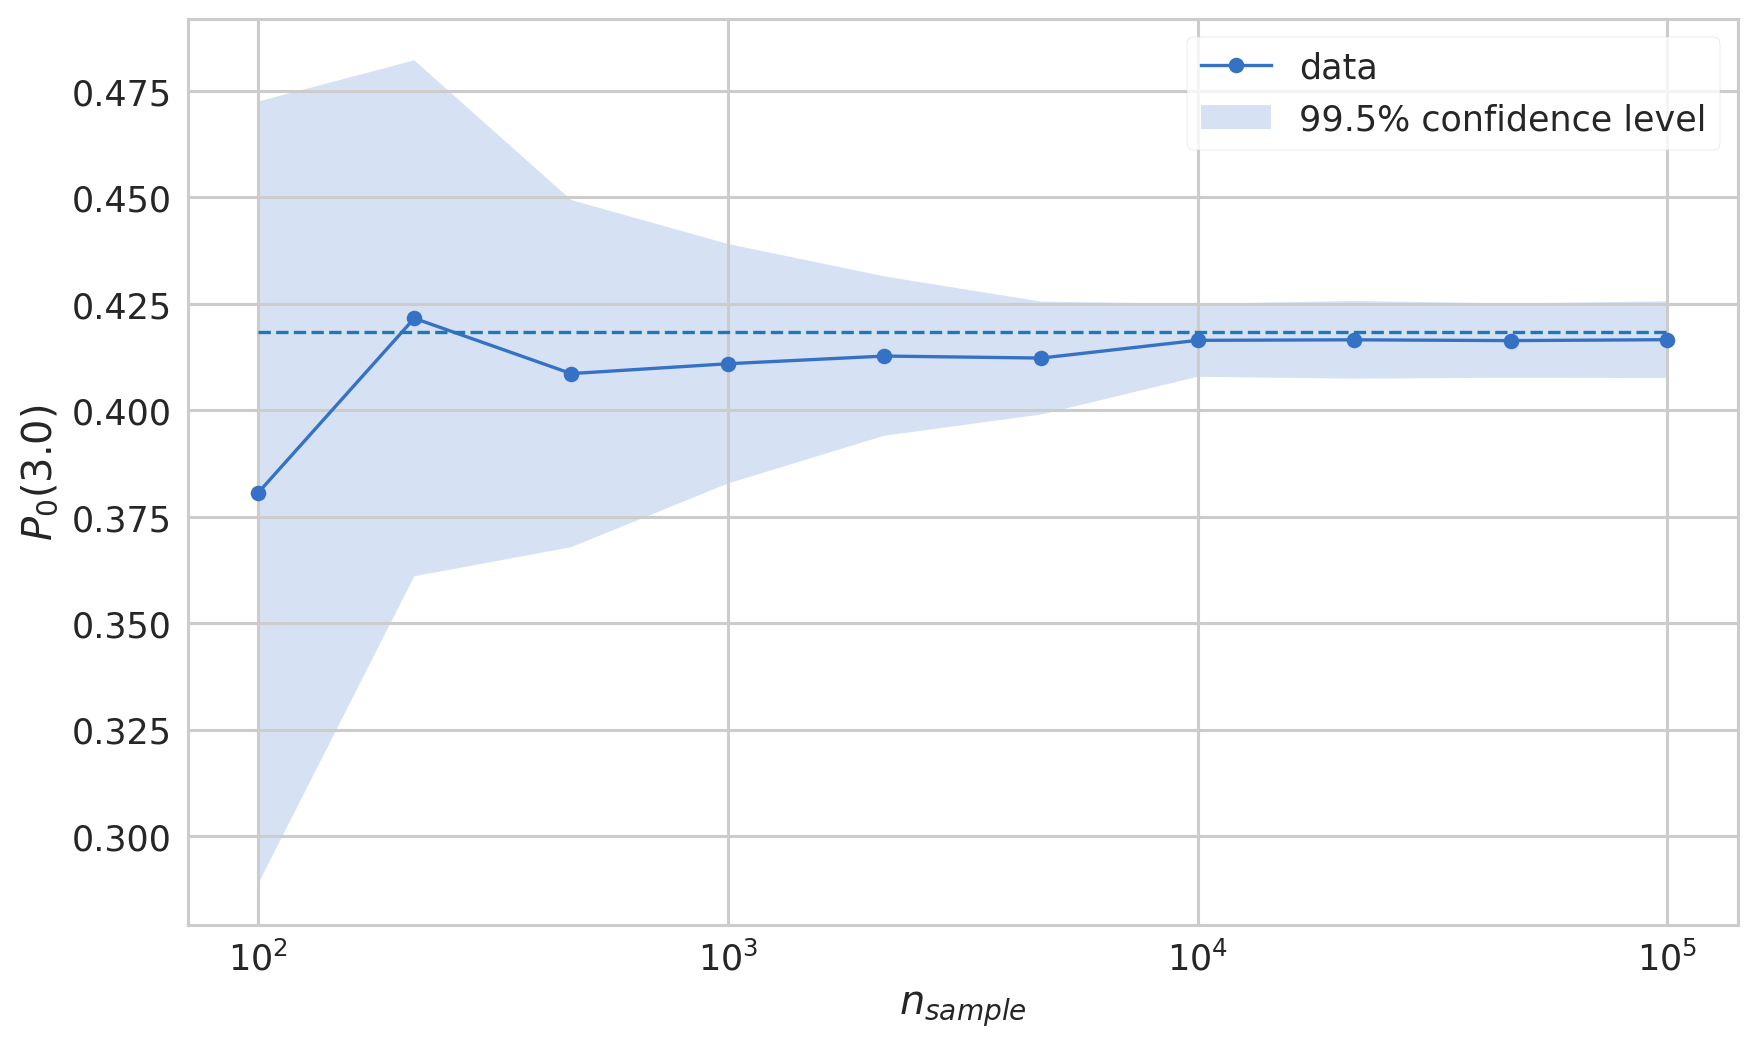

In [52]:
bootstrap_values = np.zeros((n_vals.shape[0], 2), dtype=np.double)

for i,val in enumerate(n_vals):
    bootstrap_values[i,:] = bootstrap(measurements[:val,0], 1000)
    
plt.figure(figsize=(10,6),dpi=200)
plt.plot(n_vals, bootstrap_values[:,0], "o-", label="data")
plt.fill_between(n_vals, bootstrap_values[:,0]+2.81*bootstrap_values[:,1], 
                 bootstrap_values[:,0]-2.81*bootstrap_values[:,1], alpha=0.2, label="99.5% confidence level")
plt.plot(n_vals, [data[n0,5]]*len(n_vals), linestyle="--", color="tab:blue")
plt.xscale("log")
plt.xlabel(r"$n_{sample}$")
plt.ylabel(r"$P_0(3.0)$")
plt.legend()
plt.show()